## Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
import random
import tensorflow as tf

## Import dataset

In [2]:
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

## Scale data

In [3]:
scaler=MinMaxScaler(feature_range=(0,1))

## Standardize data

In [4]:
def standardizate_data(train, test, pre_test, f30, f60, f90):
  train = np.reshape(train, (-1,1))
  train1 = scaler.inverse_transform(train)

  test = np.reshape(test, (-1,1))
  test1 = scaler.inverse_transform(test)

  pre_test = np.reshape(pre_test, (-1,1))
  pre_test1 = scaler.inverse_transform(pre_test)

  f30 = np.reshape(f30, (-1,1))
  f30_1 = scaler.inverse_transform(f30)
   
  f60 = np.reshape(f60, (-1,1))
  f60_1 = scaler.inverse_transform(f60)
  
  f90 = np.reshape(f90, (-1,1))
  f90_1 = scaler.inverse_transform(f90)
    
  return train1, test1, pre_test1, f30_1, f60_1, f90_1

## Evaluate model

In [5]:
def evaluate (forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

## Convert data

In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def convert_data(train, test, time_step):
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)

    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

## Forecast function

In [7]:
def forecast_days(model, test, time_step):
  x_input = test[len(test)-time_step:].reshape(1,-1)

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  f30=[]
  f60=[]
  f90=[]
  n_steps=time_step
  i=0
  while(i<90):
      if(len(temp_input)>time_step):
          x_input=np.array(temp_input[1:])
          # print("{} day input {}".format(i,x_input))
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1)) #3D
          yhat = model.predict(x_input, verbose=0)
          # print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          if i < 30:
            f30.extend(yhat.tolist())
          elif i < 60:
            f60.extend(yhat.tolist())
          else:
            f90.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          # print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          # print(len(temp_input))
          f30.extend(yhat.tolist())
          i=i+1
  return f30, f60, f90

## Visualize model

In [8]:
def visualize_GRU(train, test, pre_test, f30, f60, f90, time_step, ratio, currency):
    start_date = pd.to_datetime('3/1/2019')
    end_date = pd.to_datetime('6/1/2024')
    start_date_fc = pd.to_datetime('6/2/2024')
    
    index = pd.date_range(start=start_date, end=end_date, freq='d')
    forecast_index = pd.date_range(start=start_date_fc, periods=90, freq='d')
    unique_years = index.year.unique()
    x_ticks = [pd.to_datetime(str(year)) for year in unique_years]
    
    train_index = index[:len(train)]
    test_index = index[len(train): len(train) + len(test)]
    pre_test_index = index[len(train) + (time_step) : len(train) + len(test)]

    f30_index = forecast_index[:30]
    f60_index = forecast_index[30:60]
    f90_index = forecast_index[60:]
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.xticks(x_ticks, unique_years)    
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index,scaler.inverse_transform(pre_test))
    plt.plot(f30_index, scaler.inverse_transform(f30))
    plt.plot(f60_index, scaler.inverse_transform(f60))
    plt.plot(f90_index, scaler.inverse_transform(f90))
    plt.title(f'GRU model - {currency} ({int(ratio*10)}:{(10 - int(ratio*10))})')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','PredictedTest','ForecastNext30Days','ForecastNext60Days','ForecastNext90Days'])
    plt.show()

## Implement model

In [9]:
def implementGRU(train, test, ratio, currency):
  # set seed
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)
  
  time_step = 30
  X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

  # Define GRU Model
  model = Sequential()
  model.add(GRU(50, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Fit model
  model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
  
  # Predict test data
  pre_test = model.predict(X_test)
  
  # Forecase data next 30,60,90 days
  f30, f60, f90 = forecast_days(model, test, time_step)
  
  # Visualize model
  visualize_GRU(train, test, pre_test, f30, f60, f90, time_step, ratio, currency)

  # Standardize data
  train, test, pre_test, f30, f60, f90 = standardizate_data(train, test, pre_test, f30, f60, f90)
  
  # Evaluate model
  test1 = test[time_step:]
  evaluate(pre_test, test1)

# EUR_VND

In [10]:
currency = "EUR_VND"

eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
# case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
# case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

* Case 7:3

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2288 - val_loss: 0.0214
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0198 - val_loss: 0.0048
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 7.1976e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 5.7340e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.7606e-04 - val_loss: 5.2241e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1255e-04 - val_loss: 5.1655e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5940e-04 - val_loss: 5.2073e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4033e-04 - val_loss: 5.2047e-04
Epoch 12/100
21/21 ━━━━━

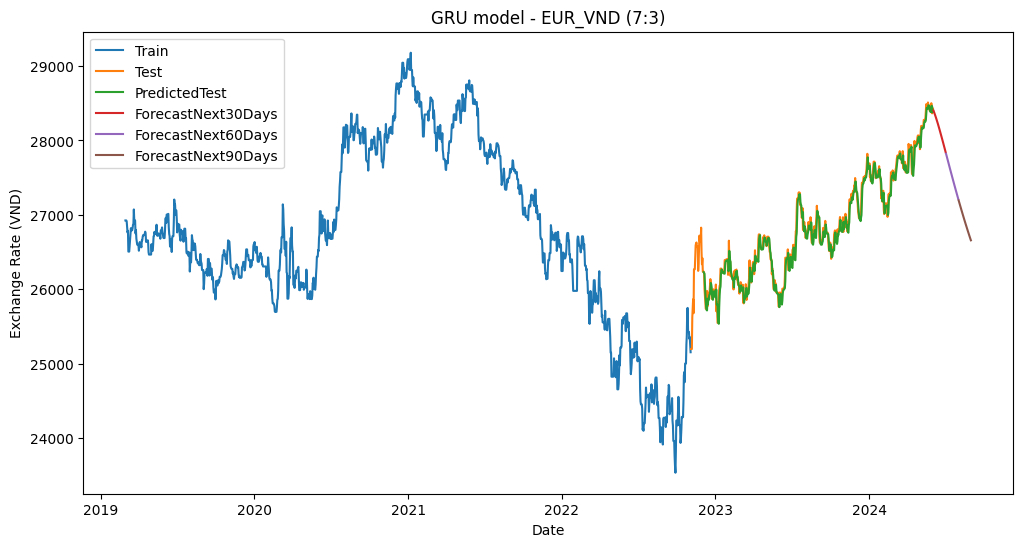

RMSE = 97.98898788688106
MAPE = 0.2623086560271644
MAE = 70.34425437843417


In [11]:
ratio = 0.7
implementGRU(train_eur_1_sc, test_eur_1_sc, ratio, currency)

* Case 8:2

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2101 - val_loss: 0.0140
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143 - val_loss: 0.0050
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - val_loss: 7.6486e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 5.7205e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010 - val_loss: 4.8499e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6632e-04 - val_loss: 4.5898e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8550e-04 - val_loss: 4.4967e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.5332e-04 - val_loss: 4.4200e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3227e-04 - val_loss: 4.3335e-04
Epoch 12/100
24/24 ━

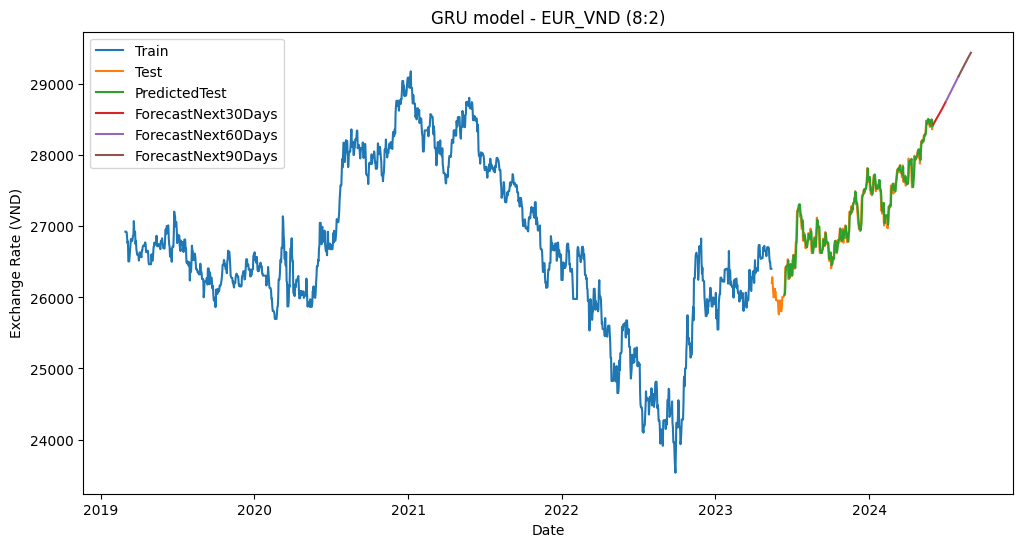

RMSE = 91.51256668797886
MAPE = 0.24341371226524167
MAE = 66.11467161016972


In [12]:
ratio = 0.8
implementGRU(train_eur_2_sc, test_eur_2_sc, ratio, currency)

* Case 9:1

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1854 - val_loss: 0.0027
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0034
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 8.6307e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 5.1930e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.2769e-04 - val_loss: 3.8323e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8510e-04 - val_loss: 3.4072e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3861e-04 - val_loss: 3.2551e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1584e-04 - val_loss: 3.1622e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.9788e-04 - val_loss: 3.0869e-04
Epoch 12/100
27/

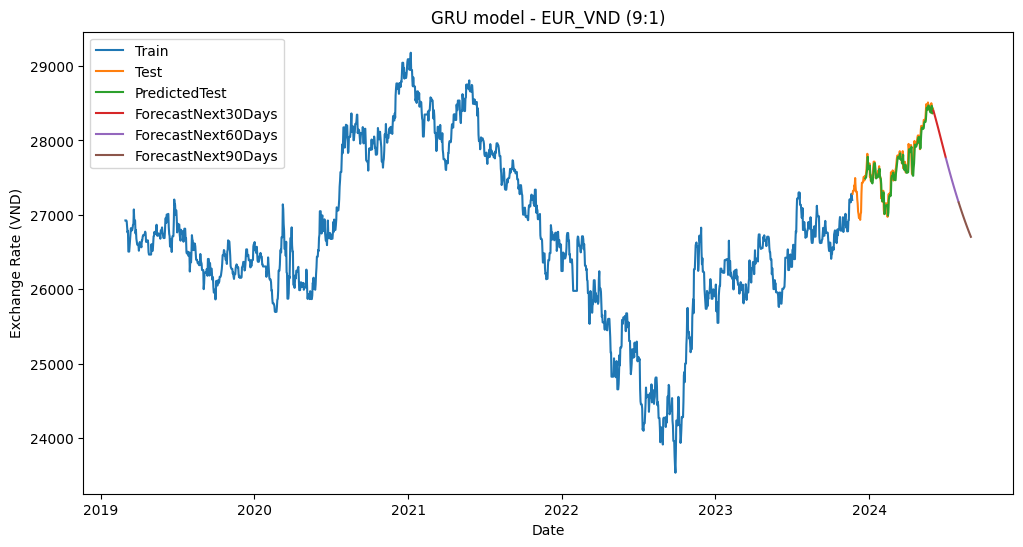

RMSE = 86.21229000130351
MAPE = 0.22935347661253877
MAE = 63.53282937885825


In [13]:
ratio = 0.9
implementGRU(train_eur_3_sc, test_eur_3_sc, ratio, currency)

# JPY_VND

In [14]:
currency = "JPY_VND"
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
  # case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

* Case 7:3

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3556 - val_loss: 0.0823
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0255 - val_loss: 0.0312
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0094 - val_loss: 0.0362
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - val_loss: 0.0230
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0041 - val_loss: 0.0163
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0102
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0695e-04 - val_loss: 0.0015
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9543e-04 - val_loss: 8.4715e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0241e-04 - val_loss: 5.7814e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1

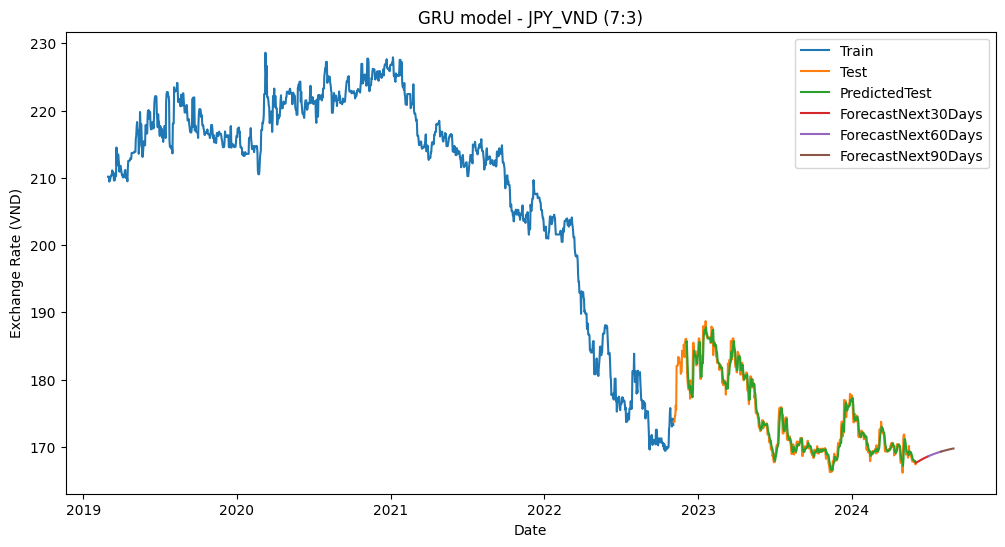

RMSE = 1.0661659981111533
MAPE = 0.40853946398931534
MAE = 0.7177940519563444


In [15]:
ratio = 0.7
implementGRU(train_jpy_1_sc, test_jpy_1_sc, ratio, currency)

* Case 8:2

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2960 - val_loss: 0.0877
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0213 - val_loss: 0.0318
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - val_loss: 0.0239
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0129
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2146e-04 - val_loss: 7.7229e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5712e-04 - val_loss: 4.4877e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1728e-04 - val_loss: 3.7527e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0240e-04 - val_loss: 3.5836e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9096e-04 - val_loss: 3.5345e-04
Epoch 12/100
24/24 ━━━━━━

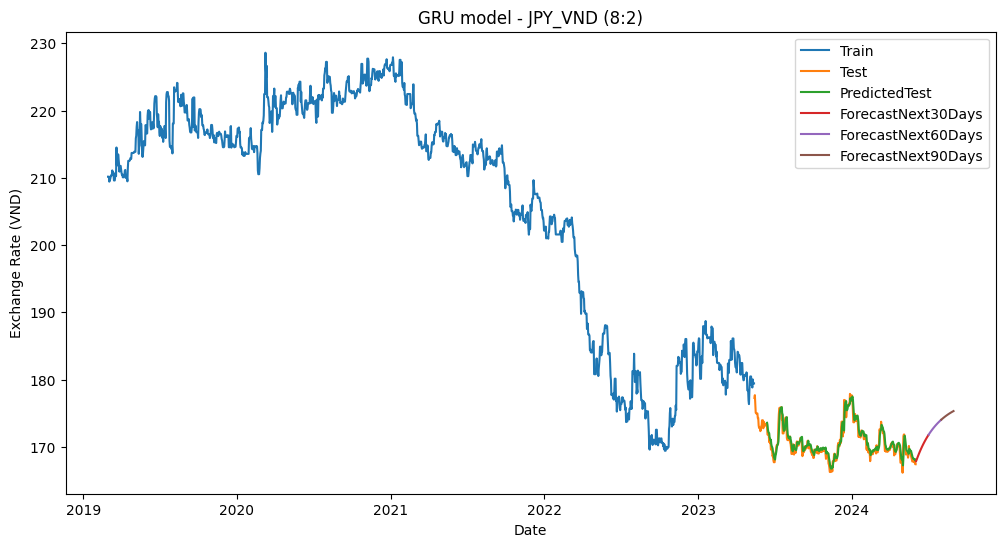

RMSE = 0.8673858216406493
MAPE = 0.3662097056384316
MAE = 0.6252394819529046


In [16]:
ratio = 0.8
implementGRU(train_jpy_2_sc, test_jpy_2_sc, ratio, currency)

* Case 9:1

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2439 - val_loss: 0.0685
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0170 - val_loss: 0.0230
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.9960e-04 - val_loss: 3.6699e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.1797e-04 - val_loss: 2.8670e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9774e-04 - val_loss: 2.8619e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8308e-04 - val_loss: 2.8460e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6994e-04 - val_loss: 2.7948e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5774e-04 - val_loss: 2.7459e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4651e-04 - val_loss: 2.7025e-04
Epoch 12

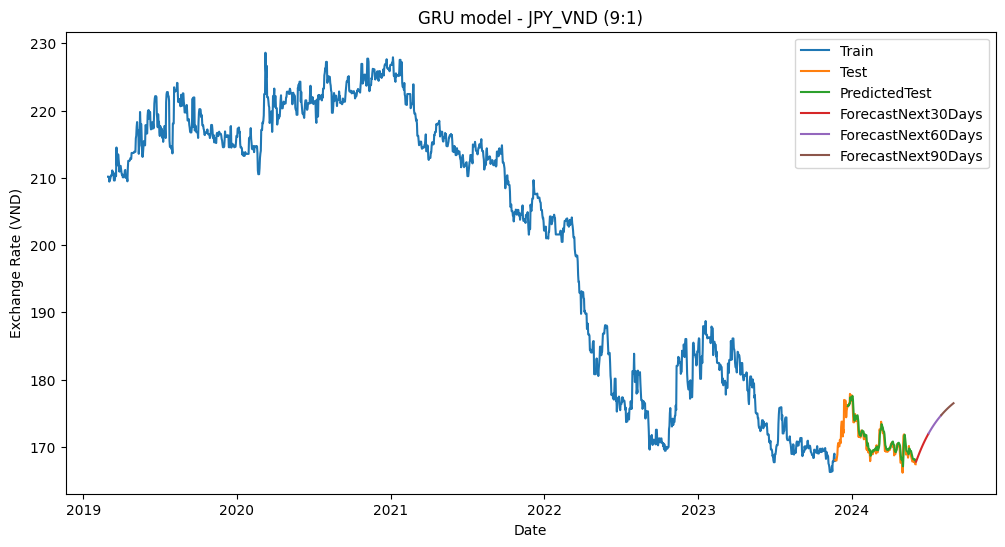

RMSE = 0.7932623839378649
MAPE = 0.3413914399027009
MAE = 0.5825443220727249


In [17]:
ratio = 0.9
implementGRU(train_jpy_3_sc, test_jpy_3_sc, ratio, currency)

# GBP_VND

In [18]:
currency = "GBP_VND"

gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
  # case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

* Case 7:3

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2531 - val_loss: 0.0194
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0192 - val_loss: 0.0081
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070 - val_loss: 0.0029
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - val_loss: 7.6088e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 6.0735e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.5337e-04 - val_loss: 5.2855e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4529e-04 - val_loss: 4.9429e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 

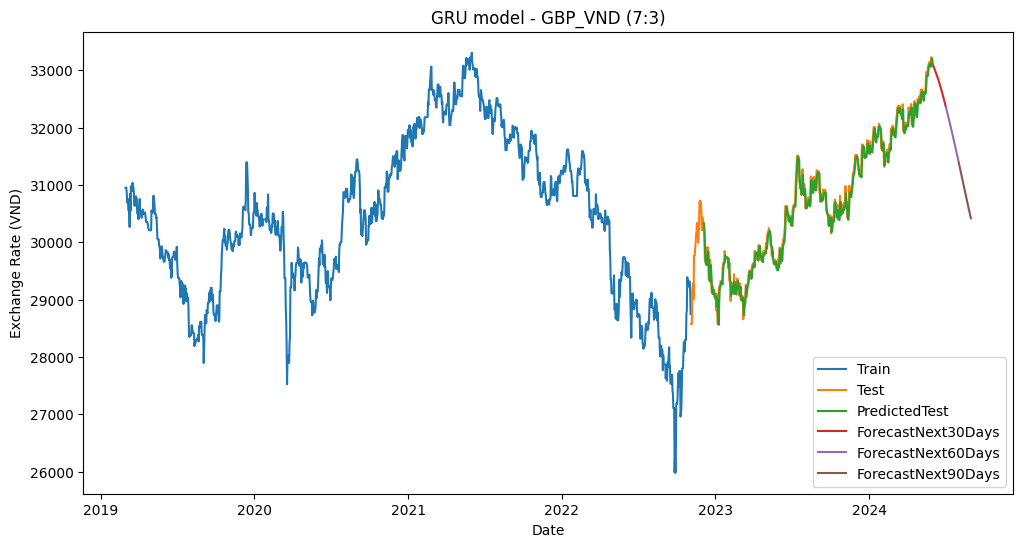

RMSE = 129.63932458363357
MAPE = 0.3071586953916605
MAE = 94.23379192422156


In [19]:
ratio = 0.7
implementGRU(train_gbp_1_sc, test_gbp_1_sc, ratio, currency)

* Case 8:2

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2311 - val_loss: 0.0118
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0144 - val_loss: 0.0093
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 7.3908e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 5.2714e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 4.3969e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0887e-04 - val_loss: 4.1057e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4314e-04 - val_loss: 4.0040e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━

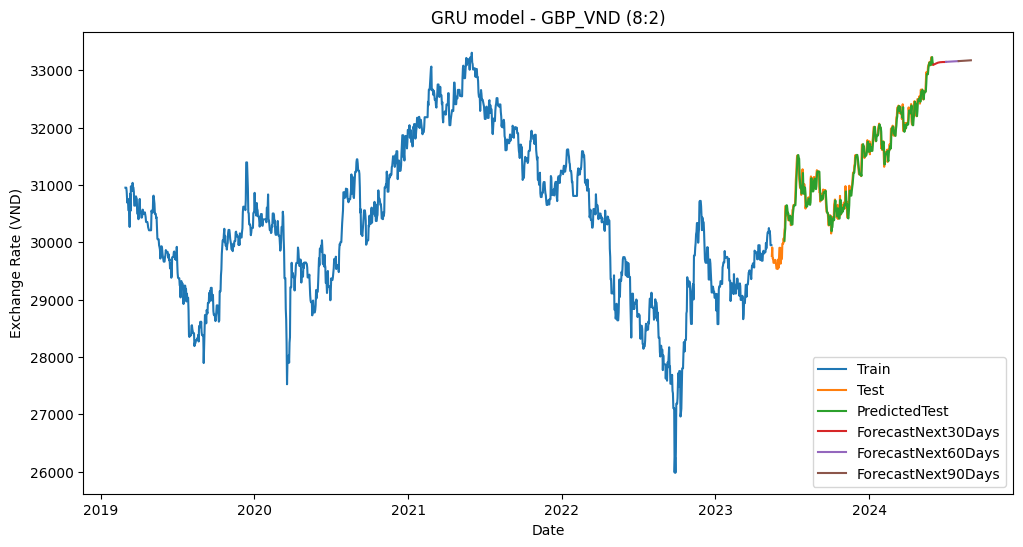

RMSE = 118.84901265809972
MAPE = 0.26746727078000226
MAE = 83.83236228813553


In [20]:
ratio = 0.8
implementGRU(train_gbp_2_sc, test_gbp_2_sc, ratio, currency)

* Case 9:1

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2021 - val_loss: 0.0017
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0067
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 7.5697e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 4.3381e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.9589e-04 - val_loss: 3.0209e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1826e-04 - val_loss: 2.6245e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7985e-04 - val_loss: 2.5099e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━

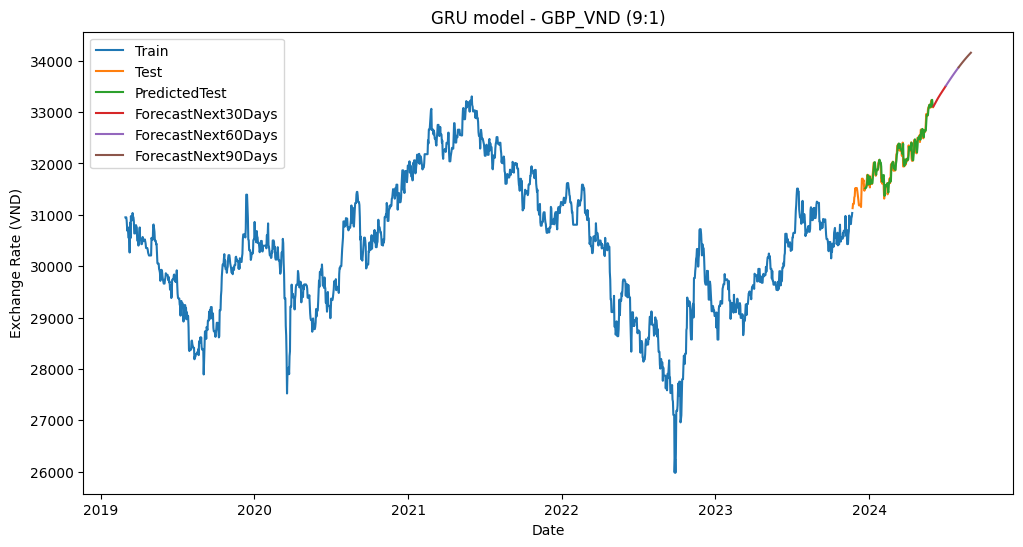

RMSE = 103.55017518924903
MAPE = 0.22770346000788302
MAE = 73.03391444830265


In [21]:
ratio = 0.9
implementGRU(train_gbp_3_sc, test_gbp_3_sc, ratio, currency)